# Documentation

**Bayesian Inference on MERRA-2 data**

**Spencer Ressel**

2023.02.07

This notebook will be used to perform Bayesian inference on data from the MERRA-2 reanalysis product: https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/

The inference will be performed to estimate the values of several parameters specified in Ahmed (2021). 

There are several dependencies for this notebook, including many standard python packages. Special packages for Bayesian inference include the *JAX* API (https://jax.readthedocs.io/en/latest/index.html) and the *numpyro* library (https://num.pyro.ai/en/latest/index.html). 
Additionally, the notebook imports the file *mjo_mean_state_diagnostics.py*, developed by Mu-Ting Chien and modified by Spencer Ressel, which contains a series of useful functions for evaluating and analyzing geophysical data relevant to the Madden-Julian Oscillation (MJO). 

# Imports

In [141]:
import numpy as np
import xarray as xr
from scipy.integrate import trapz
from scipy import signal
from scipy import special

import mjo_mean_state_diagnostics as mjo

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors as mcolors

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

# Specify constants

In [142]:
# System Parameters
LONGITUDE_MIN = 60
LONGITUDE_MAX = 130

LATITUDE_SOUTH = -15
LATITUDE_NORTH = 15

PRESSURE_LOWER = 850
PRESSURE_UPPER = 200

LOWCUT = 1/100
HIGHCUT = 1/20

# Physical constants
GRAVITY = 9.81                   # m s^-2
WATER_DENSITY = 997              # kg m^-3
LATENT_HEAT = 2.26*10**6         # J kg^-1 K^-1
SPECIFIC_HEAT = 1004             # J kg^-1

LAT_TO_DISTANCE = 111*10**3 # meters per degree latitude 

# Load data
The data are MERRA-2 netCDF files of:

* Specific Humidity
* Temperature
* Zonal Wind Velocity
* Meridional Wind Velocity
* Vertical Pressure Velocity

The data is available from 1999-01-01 to 2018-12-31, on 25 pressure levels spanning 1000 hPa to 100 hPa, with zonally global 2.5°x2.5° spatial resolution in the tropics from 20°S to 20°N.

In [143]:
# Specify data location
data_folder = r"/home/disk/eos7/sressel/Research/Data/NASA/MERRA2/"

# Load specific humidity
file_name = r"merra2_data.nc"
data = xr.open_dataset(data_folder+file_name, engine="netcdf4")

## Variables to be column-integrated
# Column Water Vapor
specific_humidity = (LATENT_HEAT/SPECIFIC_HEAT)*data['QV'].sel(
    lev = slice(PRESSURE_LOWER,PRESSURE_UPPER),
    lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH),
    lon = slice(LONGITUDE_MIN, LONGITUDE_MAX))

column_water_vapor = -((GRAVITY))*specific_humidity.integrate(dim = 'lev')
column_water_vapor = column_water_vapor.rename('CWV')
column_water_vapor.attrs['units'] = 'K kg m^-2'
column_water_vapor.attrs['long_name'] = 'Column Water Vapor'

# Calculate moisture tendency
moisture_tendency = column_water_vapor.copy(deep=True)
moisture_tendency.values = (1/(24*3600))*np.gradient(column_water_vapor, axis=0)
moisture_tendency = moisture_tendency.rename('d/dt(CWV)')
moisture_tendency.attrs['units'] = 'K kg m^-2 s^-1'
moisture_tendency.attrs['long_name'] = 'Tendency of Column Water Vapor'

# Column Integrated Temperature
temperature = data['T'].sel(
    lev = slice(PRESSURE_LOWER,PRESSURE_UPPER),
    lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH),
    lon = slice(LONGITUDE_MIN, LONGITUDE_MAX))
column_temperature = -(1/GRAVITY)*temperature.integrate(dim = 'lev')
column_temperature = column_temperature.rename('CIT')
column_temperature.attrs['units'] = 'K kg m^-2'
column_temperature.attrs['long_name'] = 'Column Integrated Temperature'


## Variables that aren't
# Zonal wind
zonal_velocity = data['U'].sel(
    lev = slice(PRESSURE_LOWER, PRESSURE_UPPER), 
    lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH),
    lon = slice(LONGITUDE_MIN, LONGITUDE_MAX)
)

# Meridional wind
meridional_velocity = data['V'].sel(
    lev = slice(PRESSURE_LOWER, PRESSURE_UPPER), 
    lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH),
    lon = slice(LONGITUDE_MIN, LONGITUDE_MAX)
)

# Vertical wind
vertical_velocity = data['OMEGA'].sel(
    lev = slice(PRESSURE_LOWER, PRESSURE_UPPER), 
    lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH),
    lon = slice(LONGITUDE_MIN, LONGITUDE_MAX)
)

# Coordinates
longitude = data['lon'].sel(lon = slice(LONGITUDE_MIN, LONGITUDE_MAX))
latitude = data['lat'].sel(lat = slice(LATITUDE_NORTH, LATITUDE_SOUTH))
pressure_levels = data['lev'].sel(lev = slice(PRESSURE_LOWER, PRESSURE_UPPER))
column_integrated_pressure = -pressure_levels.integrate(dim='lev')
time = data['time']

# Package data into a dict
variables_dict = {
    'moisture tendency':moisture_tendency,
    'column water vapor':column_water_vapor,
    'column temperature':column_temperature,
    'temperature':temperature,
    'zonal velocity':zonal_velocity,
    'meridional velocity':meridional_velocity,
    'vertical velocity':vertical_velocity
}

In [144]:
temperature = data['T']
# temperature.isel(time=0, lev=0).sel(lat=0).dropna(dim='lon')
# temperature.dropna(dim='time', how='all')
mask = temperature.sel(lev=1000).isnull().all(dim='time')
temperature = temperature.where(~mask)
temperature

<xarray.DataArray 'T' (time: 11040, lev: 25, lat: 17, lon: 144)>
array([[[[296.56833, 297.40427, 296.94333, ..., 296.9902 , 296.59177,
          296.91208],
         [296.9277 , 297.6699 , 297.78708, ..., 297.16208, 297.70895,
          296.6699 ],
         [298.40427, 298.34177, 298.0527 , ..., 298.4277 , 297.88864,
          298.72458],
         ...,
         [299.70895, 299.06833, 299.2324 , ..., 299.22458, 299.14645,
          300.3027 ],
         [298.5449 , 297.9277 , 297.9902 , ..., 298.57614, 299.2949 ,
                nan],
         [297.25583, 297.50583, 298.07614, ..., 299.46677, 298.89645,
          298.0449 ]],

        [[294.42834, 295.35022, 294.7799 , ..., 294.88147, 294.4596 ,
          294.74084],
         [294.80334, 295.50647, 295.63147, ..., 294.98303, 295.5299 ,
          294.49866],
         [296.24866, 296.19397, 295.88147, ..., 296.24866, 295.69397,
          296.5924 ],
...
         [207.00523, 207.04039, 207.38414, ..., 206.6068 , 206.82555,
          206.91148],
         [207.30211, 207.6693 , 208.18883, ..., 207.29039, 207.30602,
          207.20445],
         [207.94664, 208.1732 , 209.04039, ..., 207.82164, 207.72789,
          207.75133]],

        [[192.86295, 191.97232, 191.63638, ..., 193.13248, 193.23795,
          193.43716],
         [191.02701, 191.00357, 190.54263, ..., 191.60513, 191.44107,
          191.11295],
         [191.17545, 190.65201, 189.78482, ..., 190.02701, 190.36295,
          190.91763],
         ...,
         [190.05826, 189.63638, 189.1442 , ..., 191.53482, 191.12857,
          190.7692 ],
         [189.51138, 188.84732, 189.07388, ..., 191.25357, 191.05045,
          190.52701],
         [190.12076, 189.6442 , 188.97232, ..., 190.60513, 191.07388,
          190.8317 ]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 20.0 17.5 15.0 12.5 10.0 ... -12.5 -15.0 -17.5 -20.0
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0 100.0
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2019-12-31
Attributes:
    standard_name:   air_temperature
    long_name:       air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

In [ ]:
temperature = data['T']
mask = temperature.sel(lev=1000).isnull().any(dim='time')

for level in temperature.lev:
    temperature.loc[{'lev':level}] = temperature.sel(lev=level).where(~mask)
    
temperature

<xarray.DataArray 'T' (time: 11040, lev: 25, lat: 17, lon: 144)>
[675648000 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 20.0 17.5 15.0 12.5 10.0 ... -12.5 -15.0 -17.5 -20.0
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0 100.0
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2019-12-31
Attributes:
    standard_name:   air_temperature
    long_name:       air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

In [163]:
temperature = data['T']
mask = temperature.sel(lev=1000).isel(time=0).isnull()

<xarray.DataArray 'T' (lat: 17, lon: 144)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 20.0 17.5 15.0 12.5 10.0 ... -12.5 -15.0 -17.5 -20.0
    lev      float64 1e+03
    time     datetime64[ns] 1990-01-01

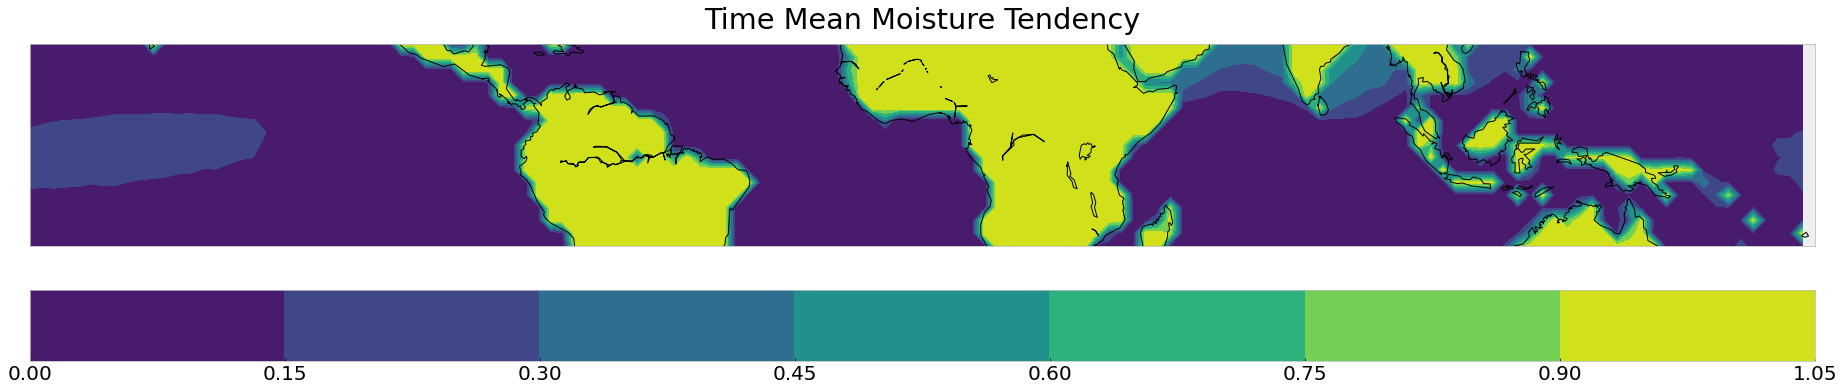

In [169]:
data_folder = r"/home/disk/eos7/sressel/Research/Data/NASA/MERRA2/"

# Load specific humidity
file_name = r"merra2_data.nc"
data = xr.open_dataset(data_folder+file_name, engine="netcdf4")

temperature = data['T']
mask = temperature.sel(lev=1000).isnull()

[longitude_mesh, latitude_mesh] = np.meshgrid(data['T'].lon, data['T'].lat)

plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(1, 1, figsize=(32, 32))

# Moisture Tendency
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = -20, urcrnrlat = 20,
            llcrnrlon = -180, urcrnrlon = 180,
            ax=ax)
m.drawcoastlines()

ax.set_title('Time Mean Moisture Tendency', pad =15)
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    mask.mean(dim='time'),
    # cmap='BrBG', 
    # cmap='viridis',
    latlon=True,
)
cbar0 = fig.colorbar(cf, ax=ax, aspect=25, pad=0.025, orientation='horizontal')

# # Add gridlines
# parallels = np.arange(-15,15,10.)
# # labels = [left,right,top,bottom]
# m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
# meridians = np.arange(60.,130.,30.)
# m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


In [168]:
temperature.sel(lev=1000).where(~mask)

<xarray.DataArray 'T' (time: 11040, lat: 17, lon: 144)>
array([[[296.56833, 297.40427, 296.94333, ..., 296.9902 , 296.59177,
         296.91208],
        [296.9277 , 297.6699 , 297.78708, ..., 297.16208, 297.70895,
         296.6699 ],
        [298.40427, 298.34177, 298.0527 , ..., 298.4277 , 297.88864,
         298.72458],
        ...,
        [299.70895, 299.06833, 299.2324 , ..., 299.22458, 299.14645,
         300.3027 ],
        [298.5449 , 297.9277 , 297.9902 , ..., 298.57614, 299.2949 ,
               nan],
        [297.25583, 297.50583, 298.07614, ..., 299.46677, 298.89645,
         298.0449 ]],

       [[297.25244, 296.49463, 296.2915 , ..., 297.74463, 297.19775,
         297.20557],
        [297.79932, 297.77588, 297.42432, ..., 297.90088, 298.229  ,
         298.104  ],
        [298.61963, 298.21338, 298.30713, ..., 299.01807, 298.80713,
         298.4165 ],
...
        [      nan,       nan,       nan, ..., 300.03168, 300.32074,
               nan],
        [      nan,       nan,       nan, ..., 299.50043, 299.14886,
               nan],
        [      nan,       nan,       nan, ..., 299.03168, 298.2348 ,
               nan]],

       [[296.14478, 296.30103, 297.4729 , ..., 295.42603, 295.5354 ,
         295.62915],
        [297.81665, 299.26196, 298.58228, ..., 296.4807 , 296.80103,
         296.5901 ],
        [299.80103, 299.51196, 299.64478, ..., 298.80884, 298.18384,
         298.1682 ],
        ...,
        [      nan,       nan,       nan, ..., 299.2229 , 300.0979 ,
         300.0901 ],
        [      nan,       nan,       nan, ..., 298.4026 , 298.76196,
               nan],
        [      nan,       nan,       nan, ..., 297.9807 , 297.9807 ,
         298.11353]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 20.0 17.5 15.0 12.5 10.0 ... -12.5 -15.0 -17.5 -20.0
    lev      float64 1e+03
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2019-12-31
Attributes:
    standard_name:   air_temperature
    long_name:       air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

## Plot data

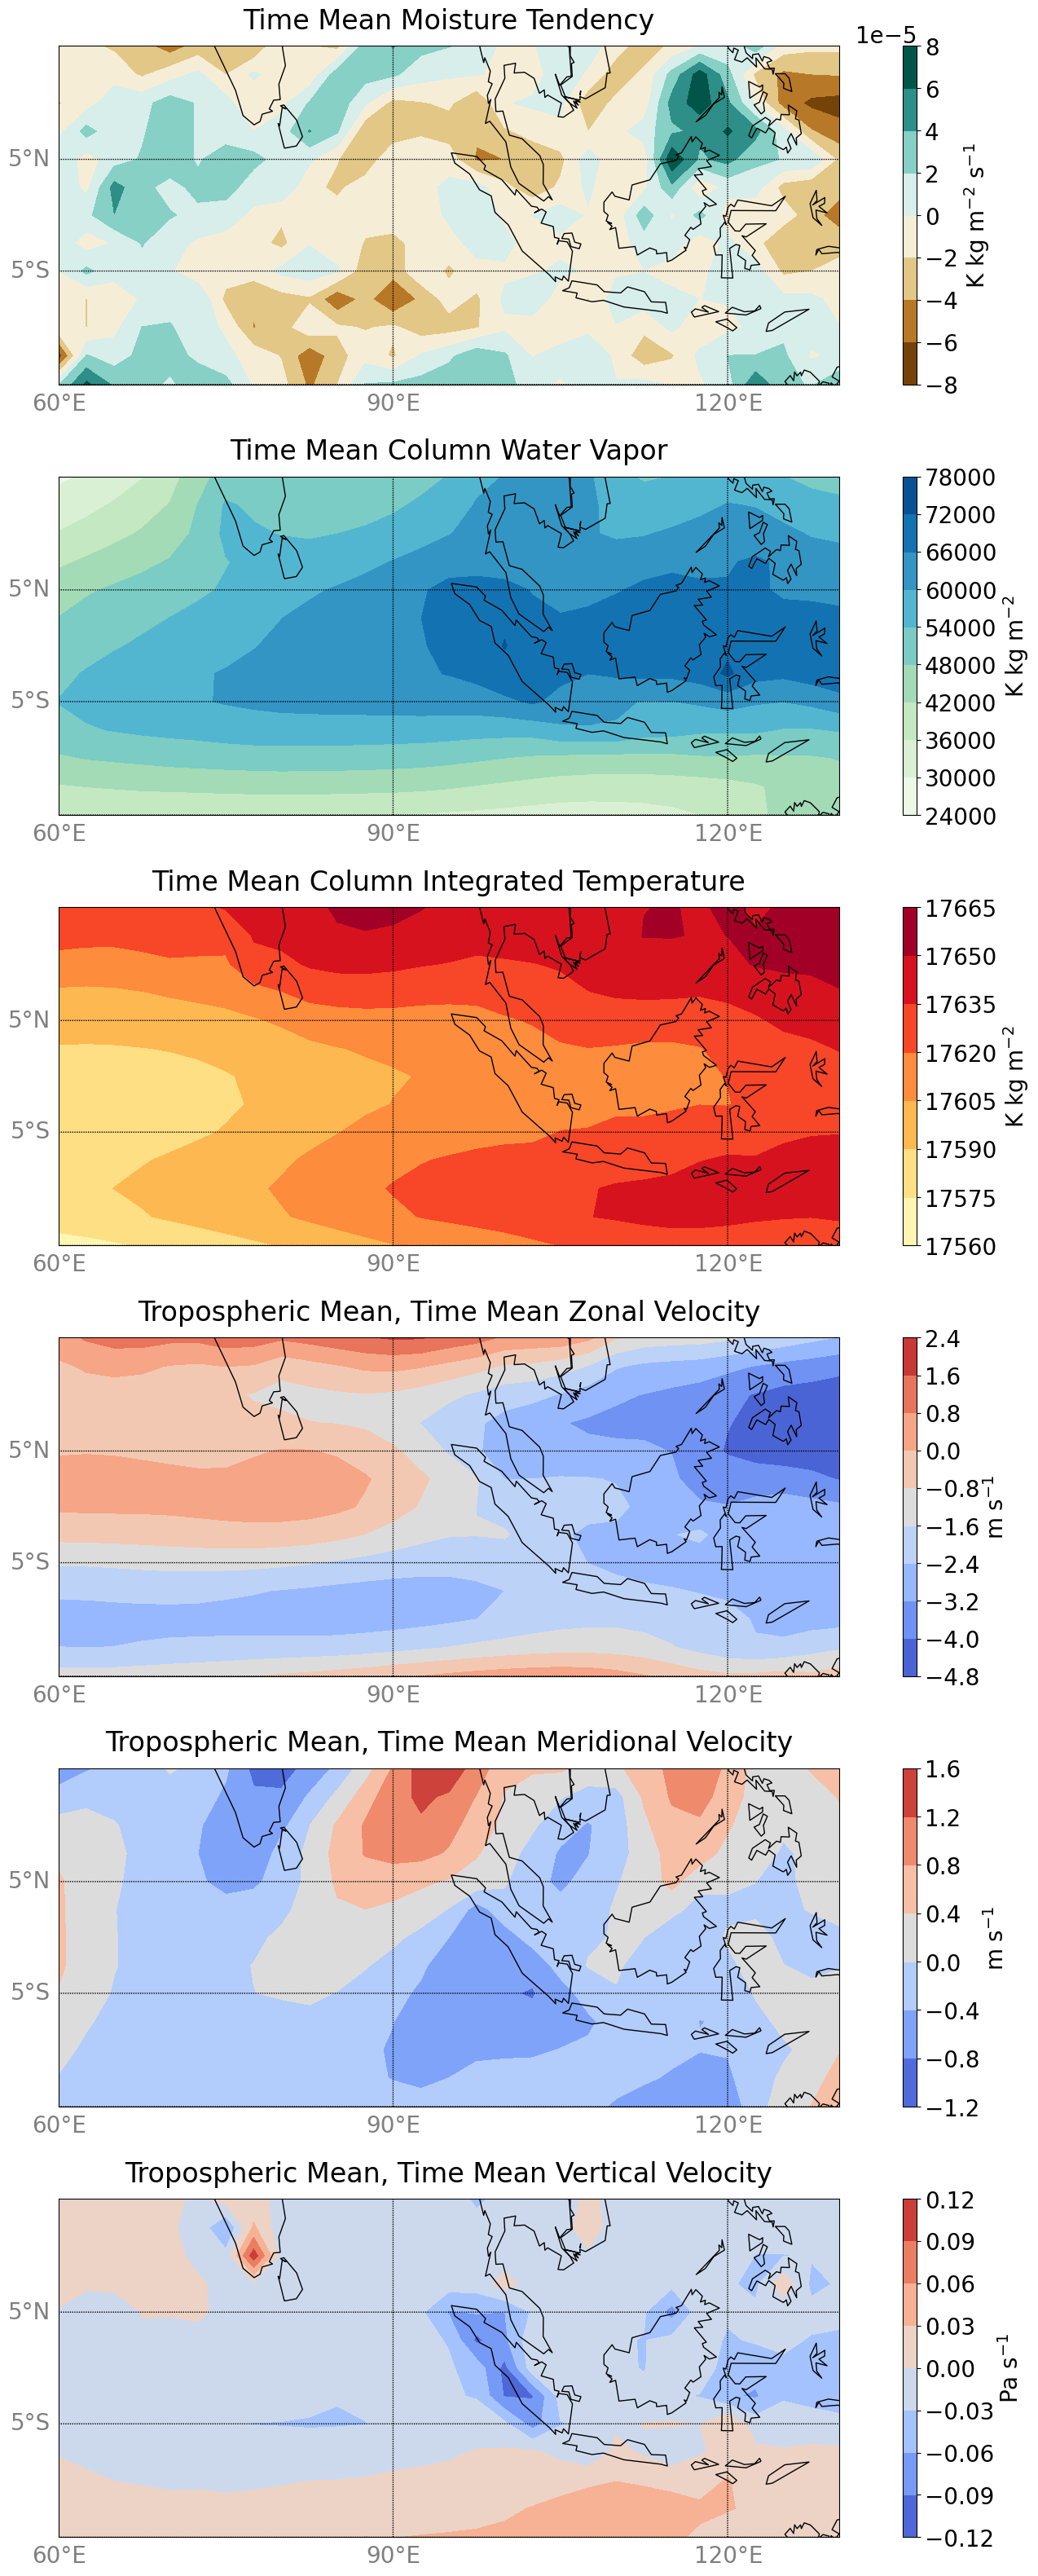

In [230]:
[longitude_mesh, latitude_mesh] = np.meshgrid(longitude, latitude)

plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(6, 1, figsize=(32, 32))

# Moisture Tendency
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[0])
m.drawcoastlines()

ax[0].set_title('Time Mean Moisture Tendency', pad =15)
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    moisture_tendency.mean(dim='time'),
    cmap='BrBG', 
    # cmap='viridis',
    latlon=True,
)
cbar0 = fig.colorbar(cf, ax=ax[0], aspect=25, pad=0.025, orientation='vertical')
cbar0.set_label(r'K kg m$^{-2}$ s$^{-1}$')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


# Column Water Vapor
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[1])
m.drawcoastlines()

ax[1].set_title('Time Mean Column Water Vapor', pad =15)
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    column_water_vapor.mean(dim='time'),
    cmap='GnBu', 
    latlon=True
)
cbar1 = fig.colorbar(cf, ax=ax[1], aspect=25, pad=0.025, orientation='vertical')
cbar1.set_label(r'K kg m$^{-2}$')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


# Column Temperature
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[2])
m.drawcoastlines()

ax[2].set_title('Time Mean Column Integrated Temperature', pad =15)
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    column_temperature.mean(dim='time'),
    cmap='YlOrRd', 
    latlon=True
)
cbar2 = fig.colorbar(cf, ax=ax[2], aspect=25, pad=0.025, orientation='vertical')
cbar2.set_label(r'K kg m$^{-2}$')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


# Zonal Velocity
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[3])
m.drawcoastlines()

ax[3].set_title(f'Tropospheric Mean, Time Mean Zonal Velocity', pad =15)
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    zonal_velocity.mean(dim=['time', 'lev']),
    cmap='coolwarm', 
    latlon=True
)
cbar3 = fig.colorbar(cf, ax=ax[3], aspect=25, pad=0.025, orientation='vertical')
cbar3.set_label('m s$^{-1}$')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


# Meridional Velocity
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[4])
m.drawcoastlines()

ax[4].set_title(f'Tropospheric Mean, Time Mean Meridional Velocity', pad =15)
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    meridional_velocity.mean(dim=['time', 'lev']),
    cmap='coolwarm', 
    latlon=True
)
cbar4 = fig.colorbar(cf, ax=ax[4], aspect=25, pad=0.025, orientation='vertical')
cbar4.set_label('m s$^{-1}$')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


# Vertical Velocity
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[5])
m.drawcoastlines()

ax[5].set_title('Tropospheric Mean, Time Mean Vertical Velocity', pad =15)
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    vertical_velocity.mean(dim=['time', 'lev']),
    cmap='coolwarm', 
    latlon=True
)
cbar5 = fig.colorbar(cf, ax=ax[5], aspect=25, pad=0.025, orientation='vertical')
cbar5.set_label('Pa s$^{-1}$')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)

plt.tight_layout()
plt.show()

# Data processing

## Detrend data in time

In [231]:
variables_detrended = {}

for variable in variables_dict:
    variables_detrended[variable] = variables_dict[variable].copy(deep=True)
    variables_detrended[variable].values = signal.detrend(variables_dict[variable], axis=0, type='linear')

## Remove the annual cycle and first three harmonics

In [232]:
variables_deannualized = {}
variables_annual_cycle = {}

# Column integrated variables
for variable in ['moisture tendency', 'column water vapor', 'column temperature']:
    variables_deannualized[variable] = variables_detrended[variable].copy(deep=True)
    variables_annual_cycle[variable] = variables_detrended[variable].copy(deep=True)
    [           
        variables_deannualized[variable].values,
        variables_annual_cycle[variable].values,
    ] = mjo.remove_annual_cycle_matrix(
        variables_detrended[variable], 
        time=time, 
        lat=latitude,
        lon=longitude
    )    
    
for variable in ['zonal velocity', 'meridional velocity', 'vertical velocity']:
    variables_deannualized[variable] = variables_detrended[variable].copy(deep=True)
    variables_annual_cycle[variable] = variables_detrended[variable].copy(deep=True)
    [           
        variables_deannualized[variable].values,
        variables_annual_cycle[variable].values,
    ] = mjo.remove_annual_cycle_matrix(
        variables_detrended[variable], 
        time=time, 
        lev=pressure_levels, 
        lat=latitude,
        lon=longitude
    )    

## Filter the data for MJO signals

In [233]:
variables_filtered = {}
for variable in variables_dict:
    variables_filtered[variable] = variables_deannualized[variable].copy(deep=True)
    variables_filtered[variable].values = mjo.lanczos_bandpass_filter(
        variables_deannualized[variable],
        lowcut = LOWCUT,
        highcut = HIGHCUT,
        fs=1,
        filter_axis=0,
    )

## Select boreal winter points
Specifically November-March

In [234]:
variables_boreal_winter = {}
variables_boreal_winter_mean = {}
winter_months = [11,12,1,2,3,4]

for variable in variables_dict:
    variables_boreal_winter[variable] = variables_filtered[variable].copy(deep=True)
    variables_boreal_winter[variable] = variables_boreal_winter[variable].sel(
        time=time['time.month'].isin(winter_months))
    
    variables_boreal_winter_mean[variable] = variables_boreal_winter[variable].mean(dim='time')
    
time_boreal_winter = time.sel(time=time['time.month'].isin(winter_months))

## Compute vertical EOF structures
First flatten the data spatially, so it has shape (len(pressure_levels), len(latitude) x len(longitude))
Then the pressure levels will be the structure dimension, and latitude and longitude will be the sampling dimension. The first EOF will be the baroclinic mode of vertical velocity

In [235]:
variables_flattened = {}
variables_array = np.empty((3*len(pressure_levels), len(latitude)*len(longitude)))

for variable in ['zonal velocity', 'meridional velocity', 'vertical velocity']:
    variables_flattened[variable] = np.reshape(
        variables_boreal_winter_mean[variable].values, 
        (
            len(pressure_levels),
            len(latitude)*len(longitude)
        )
    )


## Compute the EOF of vertical velocity and then regress others onto that

In [236]:
# Compute EOF using SVD
[
    variables_EOF,
    variables_PC, 
    eigval, 
    eigval_explained_var, 
    eigval_err, 
    dof, 
    phi_0, 
    phi_L
    ] = mjo.eof(variables_flattened['vertical velocity'])

### Plot EOF and regressed data

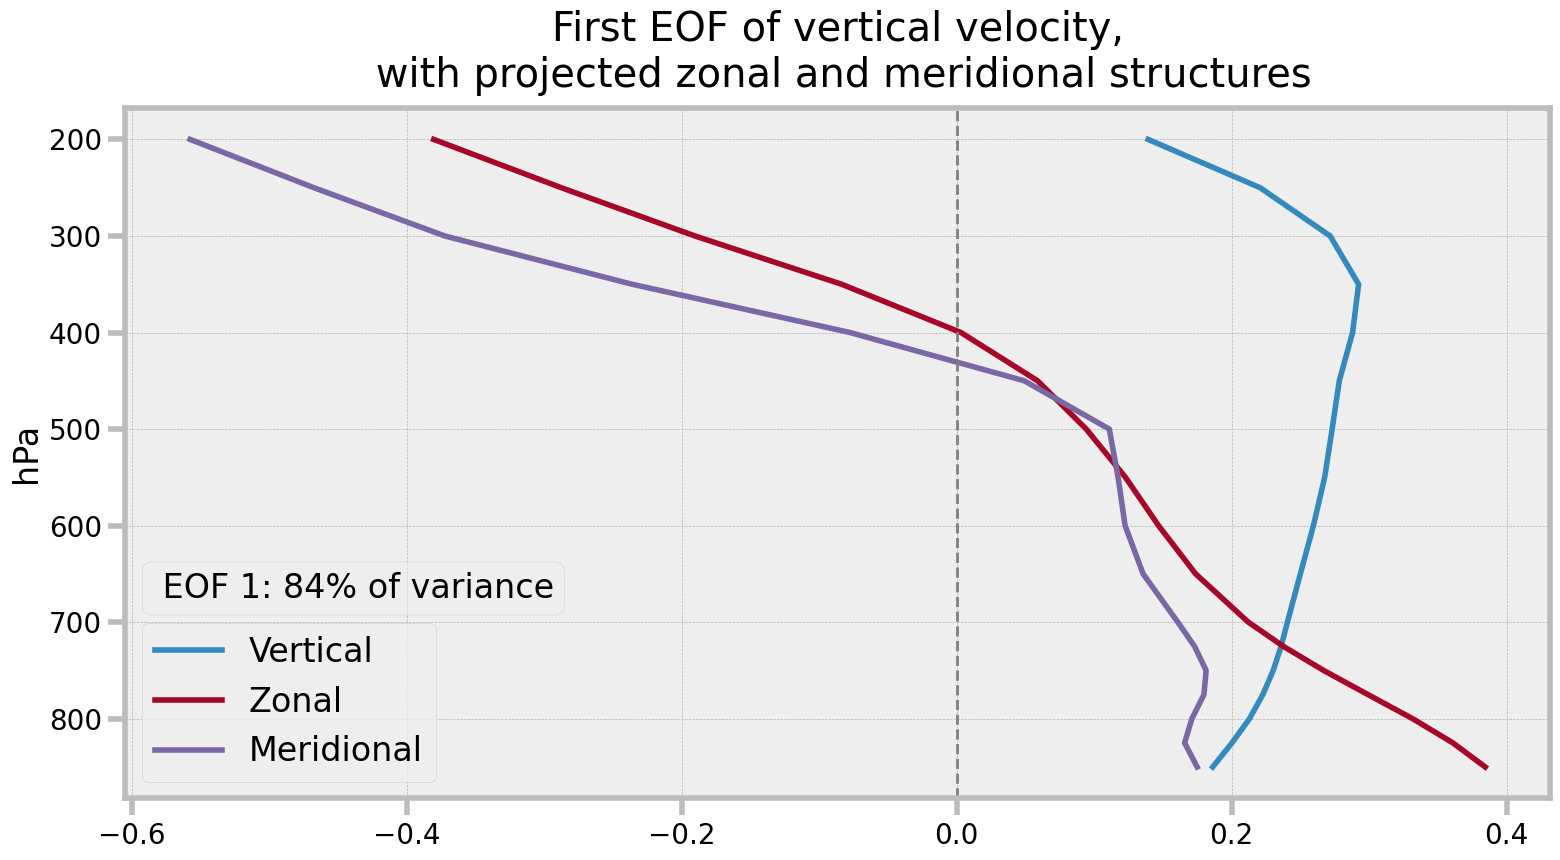

In [237]:
# Project zonal and meridional structures onto first EOF of vertical velocity
zonal_projection = np.einsum(
    'ij, j->i', 
    variables_flattened['zonal velocity'], 
    (variables_PC[0]/np.std(variables_PC[0])))/377
meridional_projection = np.einsum(
    'ij, j->i', 
    variables_flattened['meridional velocity'], 
    (variables_PC[0]/np.std(variables_PC[0])))/377


plt.style.use('bmh')
[fig, ax] = plt.subplots(figsize=(16,9))
ax.set_title(
    'First EOF of vertical velocity,'
    + '\n with projected zonal and meridional structures',
    pad=15
)

# Vertical Velocity EOF
ax.plot(
    -variables_EOF[0], 
    pressure_levels, 
    lw=4, 
    label='Vertical'
)

# Zonal Velocity projection
ax.plot(
    zonal_projection/np.linalg.norm(zonal_projection), 
    pressure_levels,
    lw=4, 
    label='Zonal'
)

# Meridional Velocity projection
ax.plot(
    meridional_projection/np.linalg.norm(meridional_projection), 
    pressure_levels,
    lw=4, 
    label='Meridional'
)

# Add vertical line at 0
ax.axvline(0, ls='--', color='gray')

# Add text showing percentage of explained variance
ax.text(-0.585,675, 
        f' EOF 1: {eigval_explained_var[0]:0.0f}% of variance', fontsize=24,
       bbox=dict(boxstyle='round', facecolor='#eeeeee', edgecolor='#bcbcbc', alpha=0.5))

# Configure and label axes
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
ax.set_ylabel('hPa')
ax.invert_yaxis()
ax.tick_params(
    axis='both', which='major', 
    length=12, width=4, 
    color='#bcbcbc', 
    direction='out', 
    pad=5
)
plt.legend(loc='lower left', fontsize=24)
plt.tight_layout()
plt.show()

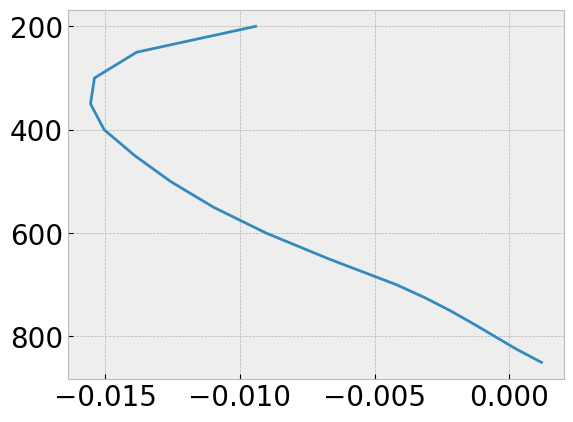

In [253]:
plt.plot(variables_dict['vertical velocity'].mean(dim=['time','lat', 'lon']), pressure_levels)
# plt.twiny()
# plt.plot(variables_EOF[0], pressure_levels, color='r')
plt.gca().invert_yaxis()

## Project data onto first EOF

In [177]:
variables_projected_vertically = {}

for variable in ['zonal velocity', 'meridional velocity', 'vertical velocity']:
    variables_projected_vertically[variable] = np.einsum(
        'j,ijkl->ikl', 
        variables_EOF[0], 
        variables_boreal_winter[variable]
    ) 

### Plot projected data

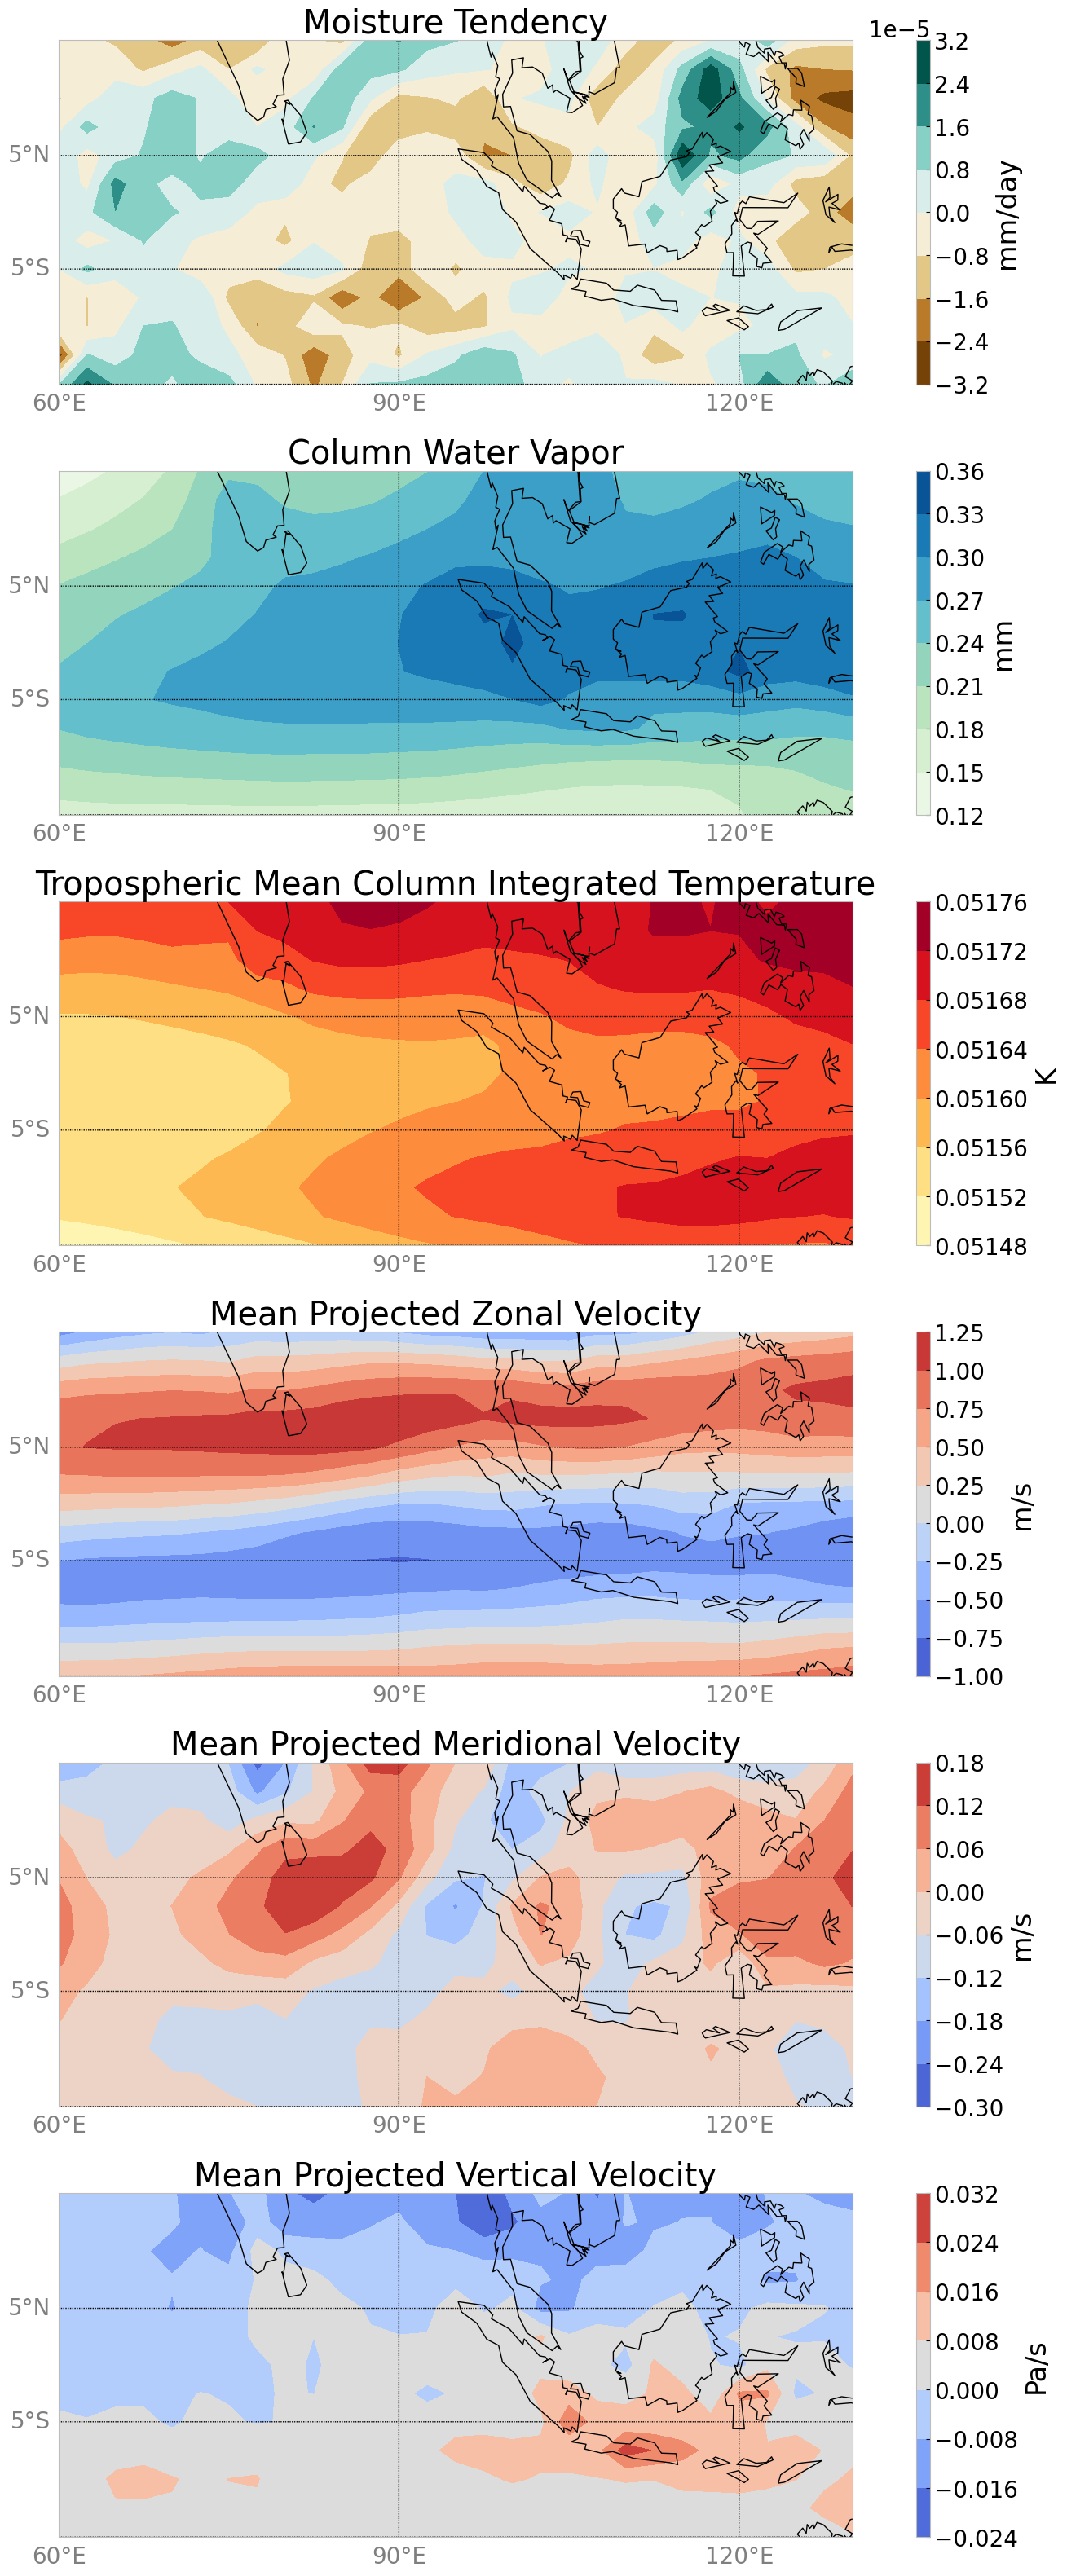

In [178]:
[longitude_mesh, latitude_mesh] = np.meshgrid(longitude, latitude)

plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(6, 1, figsize=(32, 32))

# Moisture Tendency
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[0])
m.drawcoastlines()
# m.fillcontinents(color='white')

ax[0].set_title('Moisture Tendency')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    moisture_tendency.mean(dim='time'),
    cmap='BrBG', 
    latlon=True
)
cbar0 = fig.colorbar(cf, ax=ax[0], aspect=25, pad=0.025, orientation='vertical')
cbar0.set_label('mm/day')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


# Column Water Vapor
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[1])
m.drawcoastlines()
# m.fillcontinents(color='white')

ax[1].set_title('Column Water Vapor')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    column_water_vapor.mean(dim='time'),
    cmap='GnBu', 
    latlon=True
)
cbar1 = fig.colorbar(cf, ax=ax[1], aspect=25, pad=0.025, orientation='vertical')
cbar1.set_label('mm')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


# Column Temperature
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[2])
m.drawcoastlines()
# m.fillcontinents(color='white')

ax[2].set_title('Tropospheric Mean Column Integrated Temperature')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    column_temperature.mean(dim='time')/column_integrated_pressure,
    cmap='YlOrRd', 
    latlon=True
)
cbar2 = fig.colorbar(cf, ax=ax[2], aspect=25, pad=0.025, orientation='vertical')
cbar2.set_label('K')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


# Zonal Velocity
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[3])
m.drawcoastlines()
# m.fillcontinents(color='white')
ax[3].set_title(f'Mean Projected Zonal Velocity')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    np.mean(variables_projected_vertically['zonal velocity'], axis=0),
    cmap='coolwarm', 
    latlon=True
)
cbar3 = fig.colorbar(cf, ax=ax[3], aspect=25, pad=0.025, orientation='vertical')
cbar3.set_label('m/s')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


# Meridional Velocity
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[4])
m.drawcoastlines()
# m.fillcontinents(color='white')

ax[4].set_title(f'Mean Projected Meridional Velocity')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    np.mean(variables_projected_vertically['meridional velocity'], axis=0),
    cmap='coolwarm', 
    latlon=True
)
cbar4 = fig.colorbar(cf, ax=ax[4], aspect=25, pad=0.025, orientation='vertical')
cbar4.set_label('m/s')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)


# Vertical Velocity
m = Basemap(projection='merc',
            lon_0=0, lat_0=0,
            llcrnrlat = LATITUDE_SOUTH, urcrnrlat = LATITUDE_NORTH,
            llcrnrlon = LONGITUDE_MIN, urcrnrlon = LONGITUDE_MAX,
            ax=ax[5])
m.drawcoastlines()
# m.fillcontinents(color='white')

ax[5].set_title('Mean Projected Vertical Velocity')
cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    np.mean(variables_projected_vertically['vertical velocity'], axis=0),
    cmap='coolwarm', 
    latlon=True
)
cbar5 = fig.colorbar(cf, ax=ax[5], aspect=25, pad=0.025, orientation='vertical')
cbar5.set_label('Pa/s')

# Add gridlines
parallels = np.arange(-15,15,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], color='black', alpha=0.5)
meridians = np.arange(60.,130.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True], color='black', alpha=0.5)

plt.tight_layout()
plt.show()

### Rewrite data into xarray DataArrays

In [179]:
# Rewrite vertically projected variables into xarray
variables_projected_vertically['moisture tendency'] = xr.DataArray(
    variables_boreal_winter['moisture tendency'],
    dims=['time', 'lat', 'lon'],
    coords=[time_boreal_winter, latitude, longitude]
)

variables_projected_vertically['column water vapor'] = xr.DataArray(
    variables_boreal_winter['column water vapor'],
    dims=['time', 'lat', 'lon'],
    coords=[time_boreal_winter, latitude, longitude]
)

variables_projected_vertically['column temperature'] = xr.DataArray(
    variables_boreal_winter['column temperature'],
    dims=['time', 'lat', 'lon'],
    coords=[time_boreal_winter, latitude, longitude]
)

variables_projected_vertically['zonal velocity'] = xr.DataArray(
    variables_projected_vertically['zonal velocity'],
    dims=['time', 'lat', 'lon'],
    coords=[time_boreal_winter, latitude, longitude]
)

variables_projected_vertically['meridional velocity'] = xr.DataArray(
    variables_projected_vertically['meridional velocity'],
    dims=['time', 'lat', 'lon'],
    coords=[time_boreal_winter, latitude, longitude]
)

variables_projected_vertically['vertical velocity'] = xr.DataArray(
    variables_projected_vertically['vertical velocity'],
    dims=['time', 'lat', 'lon'],
    coords=[time_boreal_winter, latitude, longitude]
)


## Project data onto meridional modes

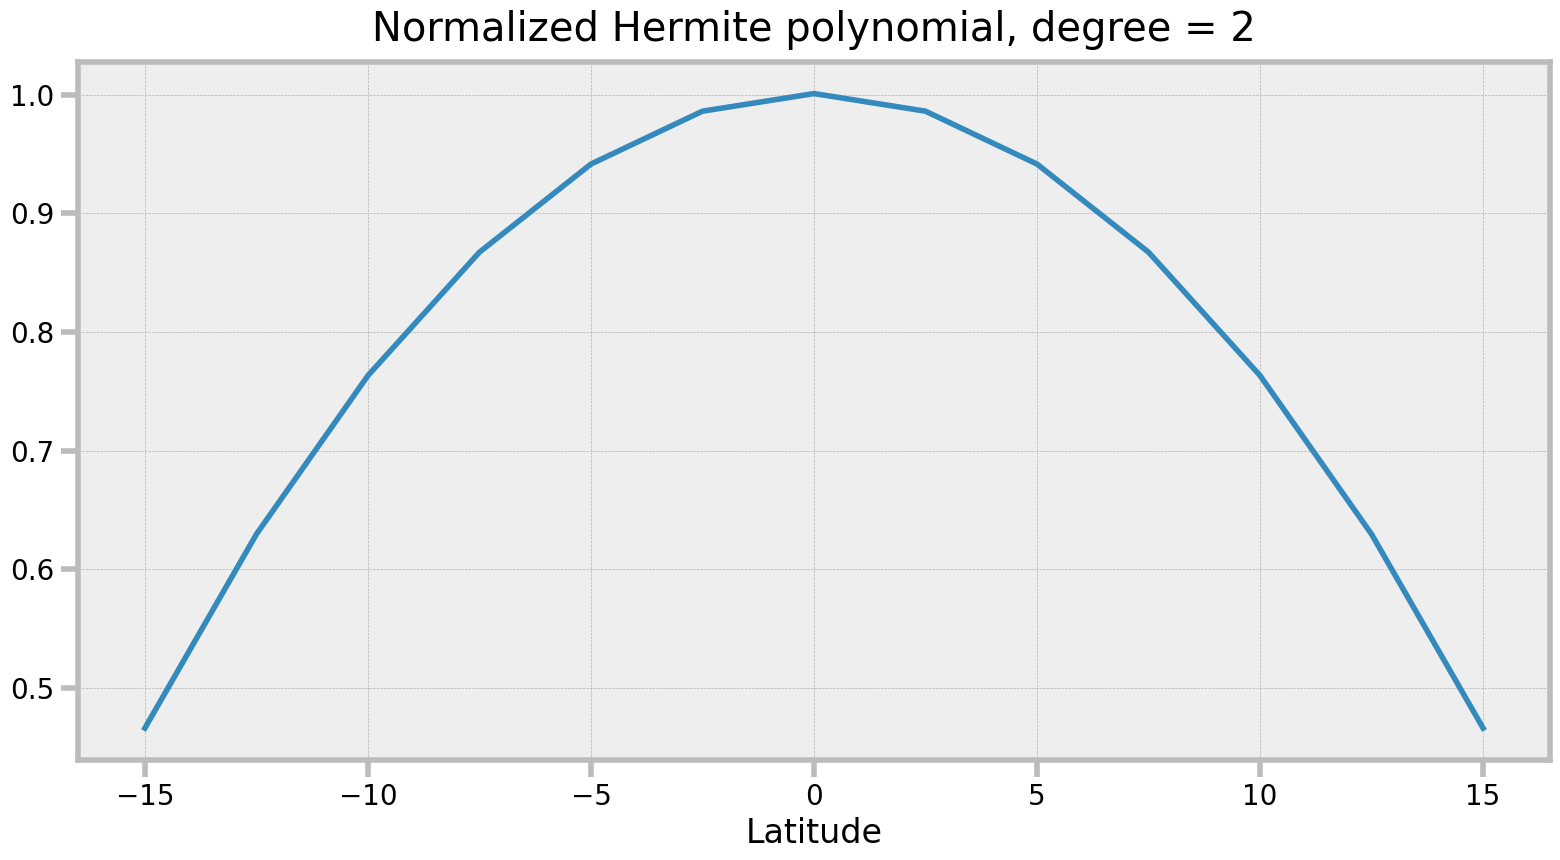

In [180]:
# Define first Hermite polynomial
n_mode = 2
meridional_mode = special.hermite(n_mode, monic=True)
meridional_mode_normalized = 1-meridional_mode(latitude)/np.linalg.norm(meridional_mode(latitude))

[fig, ax] = plt.subplots(figsize=(16,9))
ax.set_title(f'Normalized Hermite polynomial, degree = {n_mode:0.0f}', pad=15)
ax.plot(
    latitude, 
    meridional_mode_normalized,
    linewidth=4
)

# Configure labels and axes 
ax.set_xlabel('Latitude')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

ax.tick_params(
    axis='both', which='major', 
    length=12, width=4, 
    color='#bcbcbc', 
    direction='out', 
    pad=5
)
    
plt.tight_layout()
plt.show()

In [181]:
for variable in variables_dict:
    variables_meridionally_projected[variable] = (
        variables_projected_vertically[variable].copy(deep=True).sel(lat=0)
    )
    
    variables_meridionally_projected[variable].values = np.einsum(
        'ijk, j->ik',
        variables_projected_vertically[variable].values,
        meridional_mode_normalized
    )

### Plot projected data

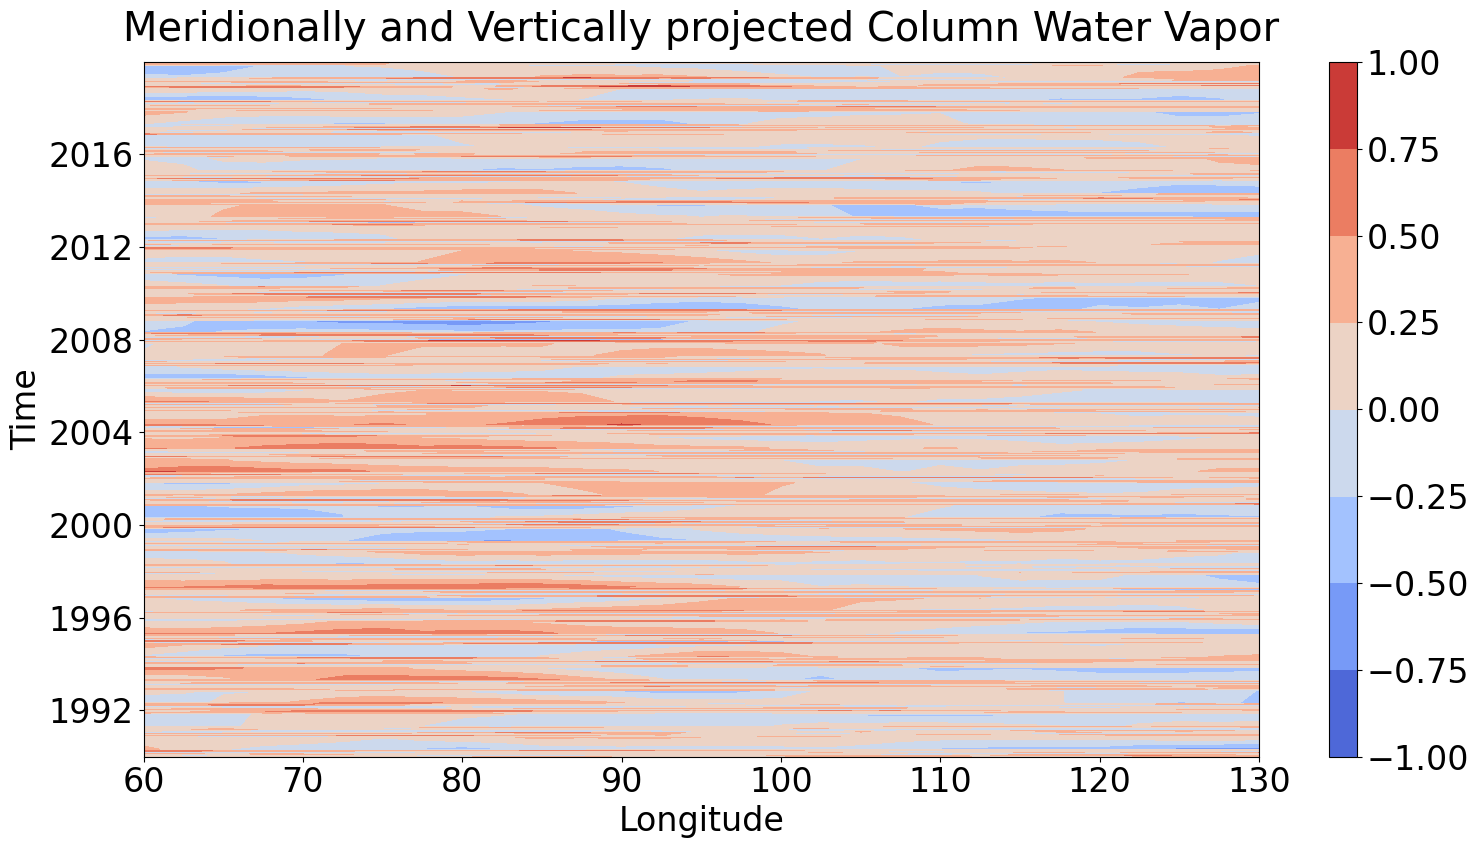

In [182]:
plt.style.use('default')
plt.rcParams.update({'font.size':24})
[fig, ax] = plt.subplots(figsize=(16,9))

ax.set_title('Meridionally and Vertically projected Column Water Vapor', pad=15)
im = ax.contourf(
    longitude, 
    time_boreal_winter,
    variables_meridionally_projected['column water vapor'],
    cmap='coolwarm'
)
cbar = fig.colorbar(im, ax=ax, aspect=25, orientation='vertical')

ax.set_xlabel('Longitude')
ax.set_ylabel('Time')

plt.tight_layout()
plt.show()

## Select a given longitude and standardize

In [186]:
longitude_point = 90

variables_longitude_point = {}

for variable in variables_meridionally_projected:
    variables_longitude_point[variable] = (
        variables_meridionally_projected[variable].copy(deep=True).sel(lon=longitude_point)
    )

## Standardize time series

In [191]:
variables_standardized = {}

for variable in variables_longitude_point:
    variables_standardized[variable] = variables_longitude_point[variable].copy(deep=True)
    variables_standardized[variable].values = (
        (
            variables_standardized[variable] - variables_standardized[variable].mean()
        ) / variables_standardized[variable].std()
    )

# Run Bayesian Inference

## Define likelihood function

In [197]:
def model(u, v, y, omega, T, q, moisture_tendency):
    sigma_x = numpyro.sample('sigma_x', dist.Uniform(-10,10))
    sigma_y = numpyro.sample('sigma_y', dist.Uniform(-10,10))
    M_q = numpyro.sample('M_q', dist.LogNormal(0, 1.0))
    epsilon_q = numpyro.sample('epsilon_q', dist.LogNormal(0, 1.0))
    epsilon_t = numpyro.sample('epsilon_t', dist.LogNormal(0, 1.0))
    dqdt = numpyro.deterministic('dqdt', sigma_x*u - sigma_y*y*v - M_q*omega - epsilon_q*q + epsilon_t*T)
    
    numpyro.sample('obs', dist.Normal(dqdt), obs=moisture_tendency)

## Run sampling algorithm

In [200]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)

# Run NUTS.
kernel = NUTS(model, adapt_step_size=True)
num_samples = 4000
mcmc = MCMC(kernel, num_chains=1, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key, 
    variables_standardized['zonal velocity'].values,
    variables_standardized['meridional velocity'].values,
    0,
    variables_standardized['vertical velocity'].values,
    variables_standardized['column temperature'].values,
    variables_standardized['column water vapor'].values,
    variables_standardized['moisture tendency'].values
    
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 5000/5000 [00:10<00:00, 459.62it/s, 7 steps of size 5.09e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        M_q      0.02      0.01      0.02      0.01      0.04   3622.96      1.00
  epsilon_q      0.05      0.01      0.05      0.03      0.07   3942.39      1.00
  epsilon_t      0.04      0.01      0.04      0.02      0.05   4046.71      1.00
    sigma_x      0.20      0.01      0.20      0.17      0.22   4642.51      1.00
    sigma_y     -0.01      5.80     -0.07     -8.00      9.90   4450.51      1.00

Number of divergences: 0


## Plot posteriors

ValueError: cannot convert float NaN to integer

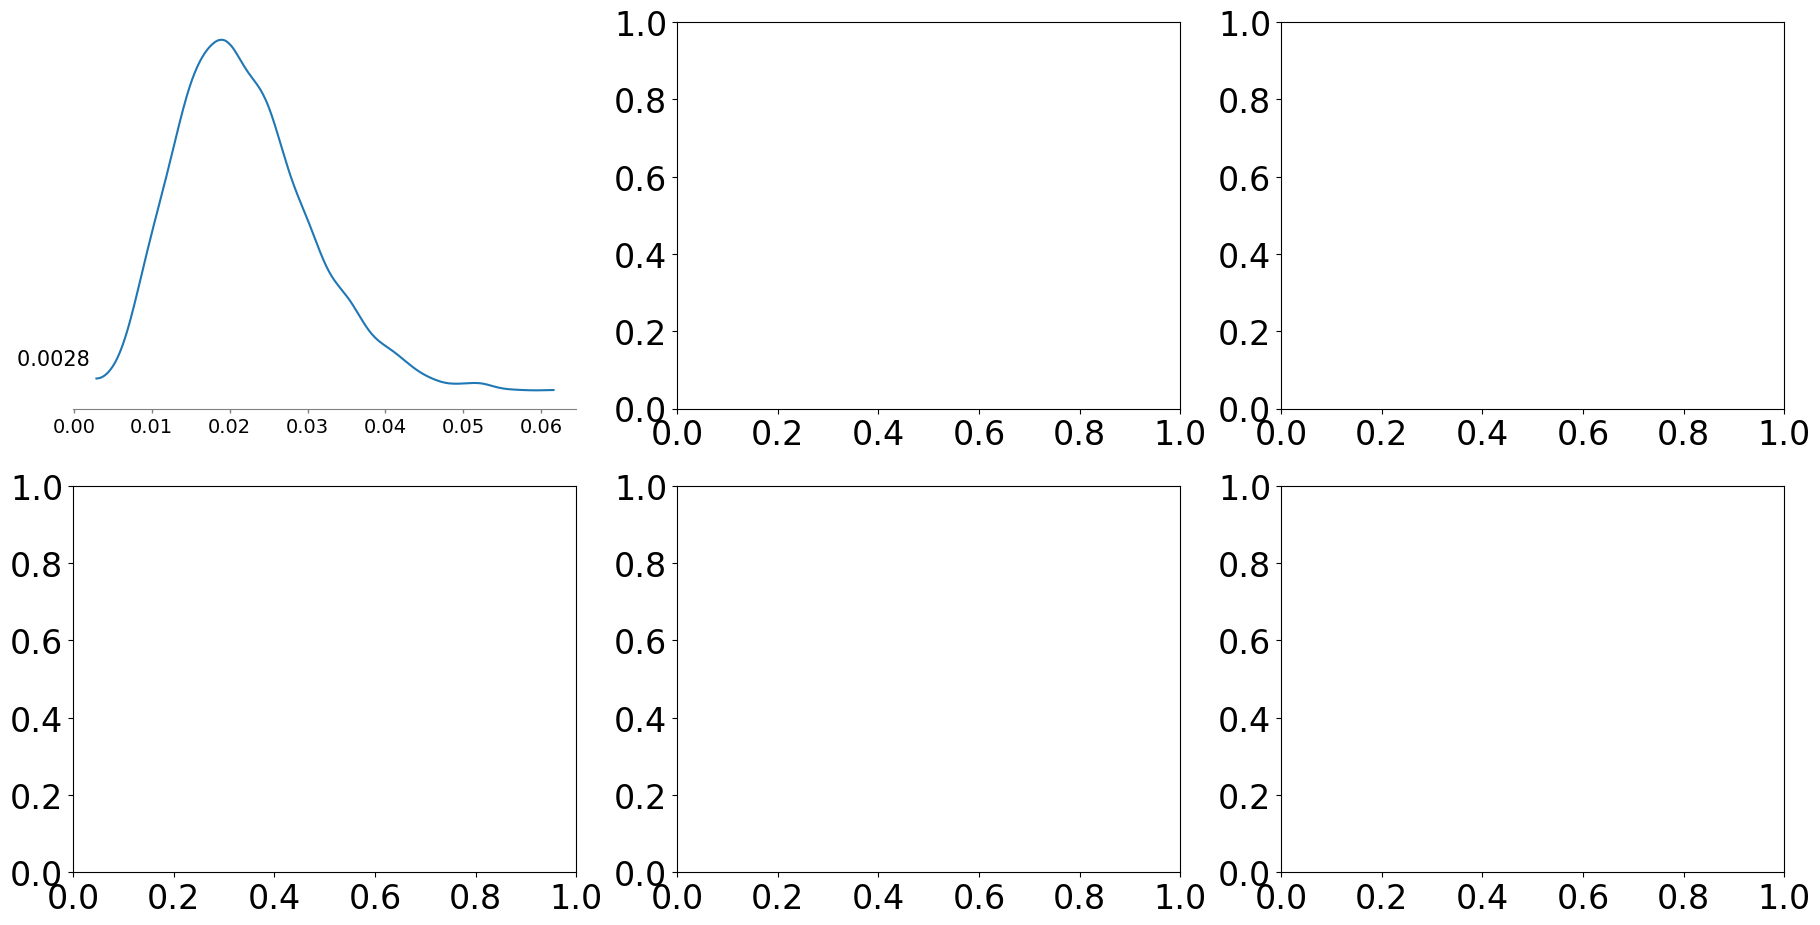

In [208]:
az.plot_posterior(samples_1)

# Testing Fiaz's numbers

In [220]:
sigma_x = 5*10**-4
sigma_y = 9*10**-9
r = 0.2
m_eff = 0.1
M_s = 3.12*10**4
m = (m_eff + r)  /(1+r)
M_q = M_s - m*M_s
epsilon_q = 1/(6*3600)
epsilon_t = 1/(2*3600)